# Day 20

For each game through Week 9 in the 2022 season, get the number of touchdowns (pass, rush, rec, special teams) and then see if any of those are significantly different than the average for the previous NFL seasons

## Set Up

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pingouin

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Get the data

In [159]:
query = """
WITH home_games AS (
    SELECT
        season,
        week,
        home_team AS team,
        home_score AS score
    FROM schedules
    WHERE week <= 9
        AND game_type = 'REG'
), away_games AS (
    SELECT
        season,
        week,
        away_team AS team,
        away_score AS score
    FROM schedules
    WHERE week <= 9
        AND game_type = 'REG'
), stacked AS (
    SELECT *
    FROM home_games
    UNION ALL
    SELECT *
    FROM away_games
), data AS (
    SELECT
        s.season,
        s.week,
        s.team,
        s.score,
        weekly_totals.tot_pass_tds,
        weekly_totals.tot_rush_tds,
        weekly_totals.tot_rec_tds, -- Will be equal to pass tds but keeping in just in case
        weekly_totals.tot_st_tds
        --(s.score / weekly_totals.tot_pass_tds + weekly_totals.tot_rush_tds) AS score_off_td_pct
    FROM stacked s
    LEFT JOIN (
        SELECT
            season,
            week,
            recent_team,
            SUM(passing_tds) AS tot_pass_tds,
            SUM(rushing_tds) AS tot_rush_tds,
            SUM(receiving_tds) AS tot_rec_tds,
            SUM(special_teams_tds) AS tot_st_tds
        FROM weekly
        GROUP BY season, week, recent_team
    ) AS weekly_totals
        ON weekly_totals.season = s.season
            AND weekly_totals.week = s.week
            AND weekly_totals.recent_team = s.team
)
SELECT
    season,
    ROUND(AVG(score),2) AS avg_score,
    ROUND(AVG(tot_pass_tds),2) AS avg_pass_tds,
    ROUND(AVG(tot_rush_tds),2) AS avg_rush_tds,
    ROUND(AVG(tot_rec_tds),2) AS avg_rec_tds,
    ROUND(AVG(tot_st_tds),2) AS avg_st_tds
    --ROUND(AVG(score / (tot_pass_tds + tot_rush_tds)),2) AS avg_score_off_td_pct
FROM data
GROUP BY season
"""

df = pd.read_sql(query, conn)
df

,season,avg_score,avg_pass_tds,avg_rush_tds,avg_rec_tds,avg_st_tds
0,1999,19.79,1.24,0.64,1.24,0.03
1,2000,20.76,1.29,0.73,1.29,0.07
2,2001,20.26,1.30,0.64,1.30,0.07
3,2002,21.93,1.37,0.86,1.37,0.09
4,2003,20.78,1.29,0.78,1.28,0.07
5,2004,21.05,1.34,0.80,1.34,0.06
6,2005,20.63,1.24,0.80,1.24,0.04
7,2006,20.63,1.34,0.75,1.34,0.05
8,2007,21.30,1.36,0.75,1.36,0.10
9,2008,22.10,1.27,0.93,1.26,0.10


## Exploration

<AxesSubplot: xlabel='avg_pass_tds', ylabel='Count'>

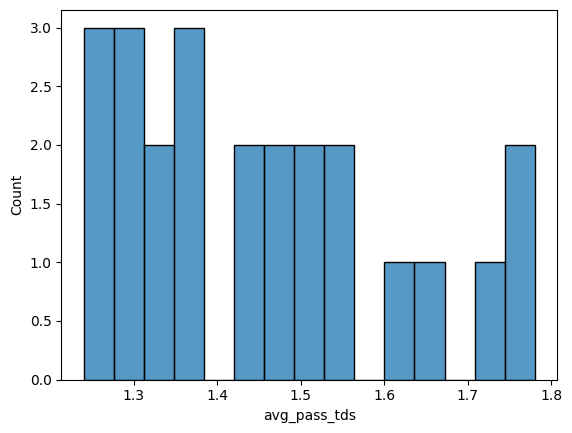

In [37]:
sns.histplot(
    x='avg_pass_tds',
    data=df,
    bins=15
)

<AxesSubplot: xlabel='avg_rush_tds', ylabel='Count'>

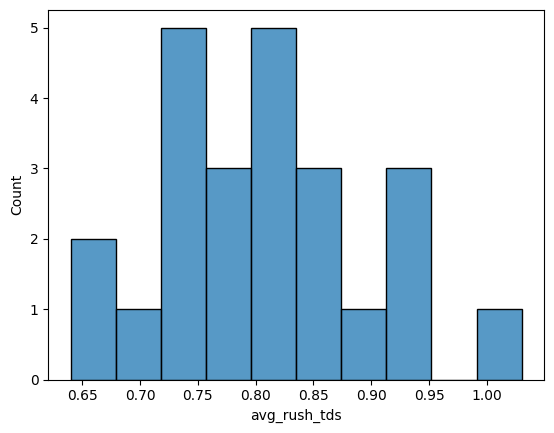

In [39]:
sns.histplot(
    x='avg_rush_tds',
    data=df,
    bins=10
)

<AxesSubplot: xlabel='avg_score', ylabel='Count'>

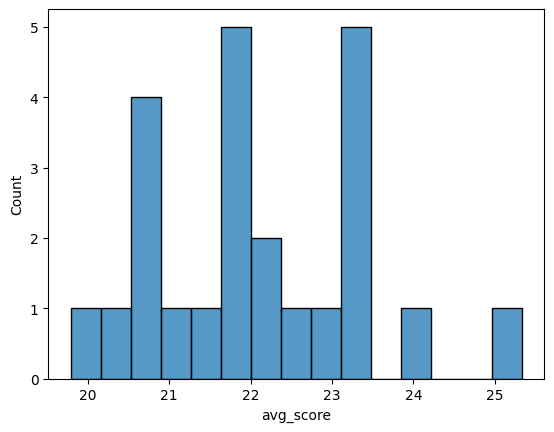

In [40]:
sns.histplot(
    x='avg_score',
    data=df,
    bins=15
)

## Hypothesis Testing

In [ ]:
# Split dataset
by_season_2022 = df[df['season'] == 2022]
by_season_1999_2021 = df[df['season'] < 2022]

print(len(by_season_1999_2021))

23


In [50]:
def run_ttest(pop_sample, sample, metric, tail):
    # Get sample means
    boot_dist = []
    for i in range(10000):
        boot_dist.append(
            # Get point estimate
            np.mean(
                # Resample
                pop_sample.sample(frac=1, replace=True)[metric]
            )
        )

    # Confirm sample means are normally distributed
    g = sns.histplot(boot_dist, bins=50)
    # g.set(
    #     xlabel="Average Score",
    #     title="Bootstrap Distribution of 10,000 23-season Samples"
    # )
    # plt.show()
    return g, pingouin.ttest(boot_dist, sample[metric].iloc[0], alternative=tail)

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


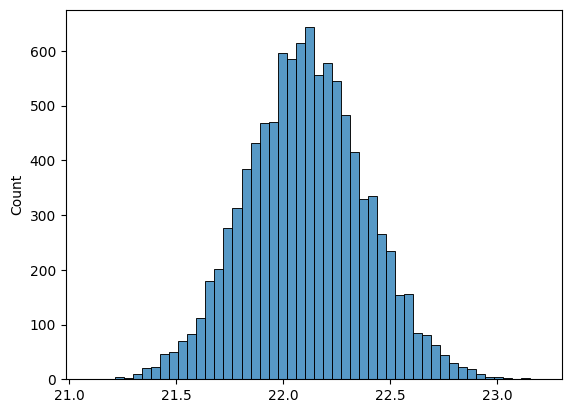

In [51]:
plot, ttest = run_ttest(by_season_1999_2021, by_season_2022, 'avg_score', 'less')

In [62]:

plt.show(plot)

In [54]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,106.457314,9999,less,1.0,"[-inf, 22.11]",1.064573,0.0e+00,0.0


/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


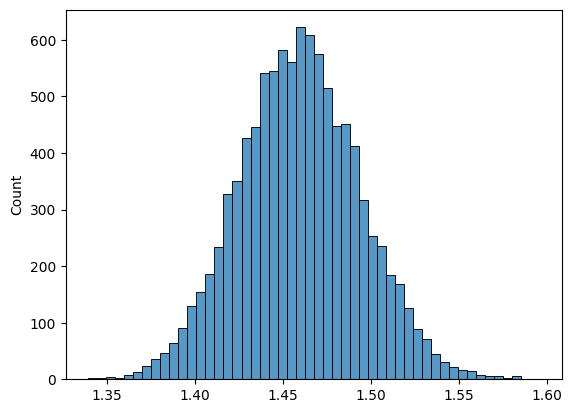

In [55]:
plot, ttest = run_ttest(by_season_1999_2021, by_season_2022, 'avg_pass_tds', 'less')

In [56]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,261.456267,9999,less,1.0,"[-inf, 1.46]",2.614563,0.0e+00,0.0


/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


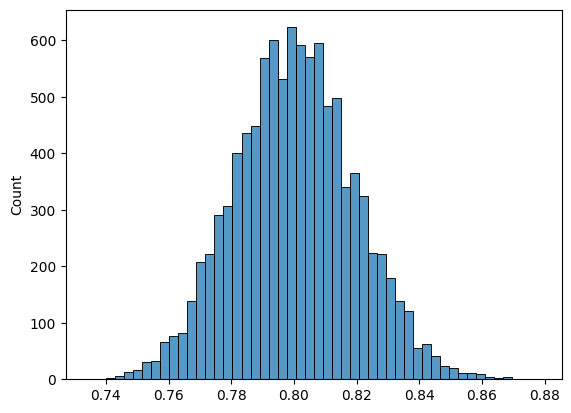

In [68]:
plot, ttest = run_ttest(by_season_1999_2021, by_season_2022, 'avg_rush_tds', 'less')

In [69]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-729.404804,9999,less,0.0,"[-inf, 0.8]",7.294048,inf,1.0


In [66]:
by_season_1999_2021.avg_rush_tds.describe()

count    23.000000
mean      0.800435
std       0.093783
min       0.640000
25%       0.750000
50%       0.800000
75%       0.855000
max       1.030000
Name: avg_rush_tds, dtype: float64